In [1]:
import os
import re
import numpy as np
import pandas as pd
import pickle as pkl
import multiprocessing
from metallum import Band, Album, Song

import nltk
from nltk.corpus import stopwords
languages = ['english', 'german', 'french', 'finnish', 'swedish', 'norwegian', 'danish', 'russian']
stop_words = set()
for language in languages:
    stop_words.update(set(stopwords.words(language)))
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, log_loss, confusion_matrix, multilabel_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from mlxtend.classifier import StackingClassifier
from imblearn.pipeline import Pipeline

from imblearn.over_sampling import RandomOverSampler, SMOTE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.utils import Sequence

from gensim.models import Word2Vec

Using TensorFlow backend.
C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Preprocessing
## Combine song lyrics with genres

In [2]:
LYRICS_DIR = 'lyrics/'
BANDS_DIR = 'bands/'

In [3]:
band_filenames = [f for f in os.listdir(BANDS_DIR) if '.pkl' in f]
bands = [pkl.load(open(os.path.join(BANDS_DIR, f), 'rb')) for f in band_filenames]
band_genres = {b.name.lower(): b.genres for b in bands}

In [4]:
lyrics_filenames = [f for f in os.listdir(LYRICS_DIR) if '.pkl' in f]
lyrics = {filename.replace('.pkl', ''): pkl.load(open(os.path.join(LYRICS_DIR, filename), 'rb')) for filename in lyrics_filenames}
corpus = []
band_names = []
song_names = []
vocabulary = set()
genres = []
for band, band_lyrics in lyrics.items():
    if band in band_genres.keys():
        for album, album_lyrics in band_lyrics.items():
            for song, song_lyrics in album_lyrics.items():
                words = []
                for line in song_lyrics:
                    for w in line.split():
                        s = re.search("(\w+)|(\w+([-'])(\w+)?[']?(\w+))", w.lower())
                        if s:
                            w = s.group()
                            if w not in stop_words:
                                words.append(w)
                song_name = []
                for w in song.split():
                    s = re.search("(\w+)|(\w+([-'])(\w+)?[']?(\w+))", re.sub('\d+\.', '', w).lower())
                    if s:
                        song_name.append(s.group())
                song_name = ' '.join(song_name)
                document = ' '.join(words)
                if len(document) > 0:
                    corpus.append(document)
                    band_names.append(band)
                    song_names.append(song_name)
                    vocabulary.update(set(words))
                    genres.append(band_genres[band])
print("vocabulary size: {}".format(len(vocabulary)))

vocabulary size: 170519


### Full lyrics + genres dataframe

In [5]:
df_rows = [
    {'band': band_names[i], 'song': song_names[i], 'lyrics': corpus[i], 'genres': genres[i]} for i in range(len(corpus))
]
df = pd.DataFrame(df_rows, columns=['band', 'song', 'lyrics', 'genres'])
df = df.drop_duplicates(subset=['band', 'song'])
print(df.shape)
df.head()

(42460, 4)


,band,song,lyrics,genres
0,aarni,myrrys,ääni tuulen varjot puiden yksinäni uneksin hal...,"[avant-garde, doom]"
1,aarni,the black keyes of r,five hundred years gone since summoned thee le...,"[avant-garde, doom]"
2,aarni,metsänpeitto sample 1 2,metsäpolulta metsän polulle metsänpeitossa for...,"[avant-garde, doom]"
3,aarni,persona mortuae cutis,yog clavis portaque cum primis digitis cutem m...,"[avant-garde, doom]"
4,aarni,ubbo,ubbo source coming zhothaqquah yok kthulhut st...,"[avant-garde, doom]"


### Statistics of song word counts

In [8]:
song_lengths = df['lyrics'].apply(lambda x: len(x.split()))
print(round(song_lengths.mean()), round(song_lengths.std()), song_lengths.min(), song_lengths.max())

85.0 44.0 1 966


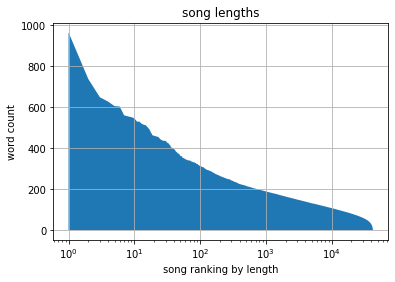

In [9]:
plt.fill_between(range(1, df.shape[0] + 1), 0, song_lengths.sort_values()[::-1].reset_index(drop=True))
plt.title("song lengths")
plt.xlabel('song ranking by length')
plt.ylabel('word count')
plt.xscale('log')
plt.grid(axis='both')
plt.show()

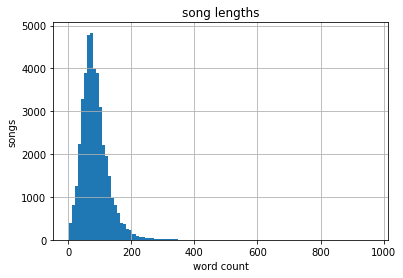

In [10]:
song_lengths.hist(bins=100)
plt.title("song lengths")
plt.xlabel('word count')
plt.ylabel('songs')
plt.show()

### Genres dataframe

In [6]:
unique_genres = []
for lst in df['genres'].tolist():
    for x in lst:
        if (x not in stop_words) and (not re.match('\-.*', x)) and (x not in unique_genres):
            unique_genres.append(x)
unique_genres.sort()

df_genres_full = pd.DataFrame(index=df.index, columns=unique_genres)
for genre in unique_genres:
    df_genres_full[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)
df_genres_full['band'] = df['band'].copy()
df_genres_bands = df_genres_full.groupby('band').max()
df_genres_full.drop('band', axis=1, inplace=True)
top_genres = df_genres_full.columns[df_genres_full.mean(axis=0) > 0.1]

genre_associations = {}
for genre in unique_genres:
    if genre not in top_genres:
        series = df_genres_bands[df_genres_bands[genre] == 1].sum(axis=0).sort_values(ascending=False)
        nearest_top_genre = series[series.index.isin(top_genres)]
        if nearest_top_genre.iloc[0] > 5 and nearest_top_genre.iloc[0] > 0.5 * series.iloc[0]:
            print(genre, nearest_top_genre.index[0], nearest_top_genre.iloc[0], series.iloc[0])
            genre_associations[genre] = nearest_top_genre.index[0]
            col = df_genres_full[nearest_top_genre.index[0]].copy()
            col[df_genres_full[genre] == 1] = 1
            df_genres_full[nearest_top_genre.index[0]] = col

top_genres = df_genres_full.columns[df_genres_full.mean(axis=0) > 0.1]
df_genres = df_genres_full[top_genres].copy()
df_genres['other'] = (df_genres.sum(axis=1) == 0).astype(int)
# df_genres.head()

ambient black 9 13
atmospheric black 8 11
brutal death 26 27
depressive black 6 7
experimental black 9 14
grindcore death 12 17
hard heavy 8 11
nwobhm heavy 6 10
pagan black 11 12
speed thrash 19 36
technical death 31 40
viking black 12 16


In [12]:
df_genres.mean(axis=0).sort_values(ascending=False)

death          0.351578
black          0.254451
thrash         0.232407
heavy          0.171244
power          0.164225
progressive    0.110551
melodic        0.106877
other          0.100141
dtype: float64

# Genre clustering

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, euclidean_distances

In [37]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(df_genres_full.values)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# print ("Cluster id labels for inputted data")
# print (labels)
# print ("Centroids data")
# print (centroids)

# print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
# print (kmeans.score(df_genres_full.values))

print ("Silhouette_score: ")
print (silhouette_score(df_genres_full.values, labels, metric='euclidean'))

Silhouette_score: 
0.21444077809732595


In [38]:
cluster_genres = []
for label in set(labels):
    df_cluster = df_genres_full[labels == label]
    df_cluster_top = df_cluster.mean(axis=0).sort_values(ascending=False)[:10]
    cluster_genres.append(list(df_cluster_top.index[df_cluster_top > 0.25]))
    print(label)
    print(df_cluster_top)

0
heavy          0.289295
progressive    0.169714
doom           0.169566
rock           0.151283
folk           0.103657
sludge         0.096137
stoner         0.079328
nwobhm         0.069006
metalcore      0.068121
industrial     0.060159
dtype: float64
1
thrash         1.000000
speed          0.829615
heavy          0.477833
power          0.307447
black          0.182846
nwobhm         0.099102
rock           0.053028
progressive    0.052738
groove         0.043755
death          0.040278
dtype: float64
2
black          1.000000
death          0.216462
folk           0.123206
viking         0.110193
melodic        0.091087
doom           0.076423
pagan          0.060312
progressive    0.059589
thrash         0.059176
gothic         0.058969
dtype: float64
3
death          1.000000
melodic        0.230604
grindcore      0.123618
technical      0.119219
brutal         0.115248
doom           0.094002
progressive    0.093787
groove         0.059556
gothic         0.052688
rock       

In [39]:
for label in set(labels):
    print(label, cluster_genres[label])

0 ['heavy']
1 ['thrash', 'speed', 'heavy', 'power']
2 ['black']
3 ['death']
4 ['power', 'heavy']
5 ['thrash', 'death']
6 ['symphonic', 'power']
7 ['rock', 'heavy', 'hard', 'progressive']


In [40]:
df_genre_vectors = pd.DataFrame(euclidean_distances(df_genres_full.values, centroids), columns=sorted(set(labels)))

In [41]:
df_genre_vectors[:4000:100]

,0,1,2,3,4,5,6,7
0,1.353370,2.016964,1.701539,1.707861,1.788851,1.848096,1.801890,2.047498
100,1.105600,1.643914,0.346946,1.458903,1.483235,1.500923,1.499412,1.886566
200,1.105600,1.728464,1.299018,0.358327,1.483235,1.128619,1.499412,1.836008
300,1.449839,1.909360,1.020423,1.754657,1.788851,1.787242,1.802286,2.135212
400,1.480533,1.982915,1.630944,1.052213,1.788851,1.497270,1.802286,2.090676
500,1.795091,1.619227,1.252636,1.458903,2.036873,1.054084,2.048272,2.276558
600,0.802347,1.453437,1.441824,1.458903,1.201428,1.548503,1.516923,1.248652
700,0.802347,1.453437,1.441824,1.458903,1.201428,1.548503,1.516923,1.248652
800,1.490755,1.903128,0.829125,1.062261,1.788851,1.452960,1.787573,2.090676
900,1.105600,1.728464,1.299018,0.358327,1.483235,1.128619,1.499412,1.836008


# Train-test split

In [7]:
corpus_train, corpus_test, y_train, y_test = train_test_split(df['lyrics'].values, df_genres.values, test_size=0.2)

# Word2Vec

### Create and save Word2Vec model

In [13]:
# sentences = df.lyrics.str.split().tolist()
# word2vec_model = Word2Vec(sentences, size=400, window=5, min_count=5, workers=multiprocessing.cpu_count())
# word2vec_model.save('word2vec.model')

### Load untrained model

In [3]:
# word2vec_model = Word2Vec.load('word2vec.model')
# word_vectors = word2vec_model.wv
# del word2vec_model

C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Train and save trained model

In [16]:
# sentences_train = [doc.split() for doc in corpus_train]
# word2vec_model = Word2Vec(sentences_train, size=400, window=3, min_count=20, workers=multiprocessing.cpu_count())
# word2vec_model.save('word2vec_train.model')

### Load trained model

In [8]:
word2vec_model = Word2Vec.load('word2vec_train.model')
word_vectors = word2vec_model.wv
del word2vec_model
print(len(word_vectors.vocab))

C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


11038


In [12]:
word = 'fire'
print(word, word_vectors.vocab[word].count)
for w in word_vectors.vocab.keys():
    dist = word_vectors.similarity(word, w)
    if dist > 0.7:
        print(w, dist)

fire 7544
flame 0.7486245100503697
fire 0.9999999999999998
flames 0.7578097676571045


In [19]:
print(word_vectors.doesnt_match("fire dragon candle torch".split()))

dragon


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\gensim\models\keyedvectors.py:730: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


### Create tokenized train/test matrices and embedding matrix

In [9]:
max_length = 300
t = Tokenizer()
t.fit_on_texts(corpus_train)
corpus_train_enc = t.texts_to_sequences(corpus_train)
corpus_test_enc = t.texts_to_sequences(corpus_test)
corpus_train_pad = pad_sequences(corpus_train_enc, maxlen=max_length, padding='post')
corpus_test_pad = pad_sequences(corpus_test_enc, maxlen=max_length, padding='post')
print(corpus_train_pad.shape, corpus_test_pad.shape)

(33968, 300) (8492, 300)


In [10]:
vocab_size = len(t.word_index) + 1
vector_dim = word_vectors.vector_size
embedding_matrix = np.zeros((vocab_size, vector_dim))
for word, i in t.word_index.items():
    try:
        embedding_vector = word_vectors[word]
    except KeyError:
        pass
    else:
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(147587, 400)


# Multi-label classification metrics

In [12]:
class MultiLabelClassification:

    def __init__(self, y_true, y_pred=None, y_pred_classes=None, labels=None, class_thresh=0.5):
        self.true = y_true
        if y_pred_classes is None and y_pred is not None:
            self.pred = y_pred
            y_pred_classes = np.zeros_like(self.pred, dtype=int)
            y_pred_classes[self.pred > class_thresh] = 1
        else:
            self.pred = None
        self.pred_classes = y_pred_classes
        self.n_samples, self.n_labels = y_true.shape
        if labels is not None:
            if len(labels) == self.n_labels:
                self.labels = np.array(labels)
            else:
                raise ValueError("length of labels and shape of y_true do not match")
        else:
            self.labels = np.arange(self.n_classes)

    @property
    def __intersection(self):
        return self.true * self.pred_classes

    @property
    def __union(self):
        return np.minimum(1, self.true + self.pred_classes)

    @property
    def accuracy_score(self):
        # Number of labels in common / overall labels (true and predicted)
        return np.mean(self.__intersection.sum(1) / self.__union.sum(1))

    @property
    def precision_score(self):
        # Proportion of predicted labels that are correct
        return np.nanmean(self.__intersection.sum(1) / self.pred_classes.sum(1))

    @property
    def recall_score(self):
        # Proportion of true labels that were predicted
        return np.mean(self.__intersection.sum(1) / self.true.sum(1))

    @property
    def f1_score(self):
        # Harmonic mean of precision_score and recall_score
        p = self.precision_score
        r = self.recall_score
        return 2 * (p * r) / (p + r)

    def confusion_matrix(self, label=None, label_idx=None):
        confusion_matrices = multilabel_confusion_matrix(self.true, self.pred_classes)
        if label is not None:
            return confusion_matrices[np.where(self.labels == label)[0][0]]
        elif label_idx is not None:
            return confusion_matrices[label_idx]
        else:
            return confusion_matrices

    def print_report(self, verbose=0):
        print("Multi-label classification report")
        print("Accuracy:   {:.2f}".format(self.accuracy_score))
        print("Precision:  {:.2f}".format(self.precision_score))
        print("Recall:     {:.2f}".format(self.recall_score))
        print("F1-score:   {:.2f}".format(self.f1_score))
        if verbose == 1:
            for label, matrix in zip(self.labels, self.confusion_matrix()):
                print("===\nLabel: {}".format(label))
                print(matrix)

# Convolutional Neural Network

In [13]:
def create_keras_model(nb_classes=1, conv_nb_filters=(64,), conv_kernel_size=(5,), fc_size=(64,)):
    keras_model = Sequential()
    keras_model.add(layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_length, trainable=False))
    if len(conv_nb_filters) != len(conv_kernel_size):
        raise ValueError("n_conv_filters and conv_size must be same length")
    for nb_filters, kernel_size in zip(conv_nb_filters, conv_kernel_size):
        keras_model.add(layers.Conv1D(nb_filters, kernel_size, activation='relu'))
        keras_model.add(layers.MaxPooling1D(2))
    keras_model.add(layers.Flatten())
    for fc_size_ in fc_size:
        keras_model.add(layers.Dense(fc_size_, activation='relu'))
    keras_model.add(layers.Dense(nb_classes, activation='sigmoid'))
    keras_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    return keras_model


class BatchGenerator(Sequence):

    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_X = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return batch_X, batch_y

### Cross-validation training

In [14]:
# Training parameters
X_train = corpus_train_pad
X_test = corpus_test_pad
epochs = 1
batch_size = 64
oversampler = RandomOverSampler(random_state=0)

# Cross-validation
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# Model parameters
model_params = dict(
    nb_classes=y_train.shape[1],
    conv_nb_filters=(32, 32),
    conv_kernel_size=(4, 2),
    fc_size=(1024,)
)

results = []
for i, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train.argmax(1))):
    print("-----\nCV fold {}".format(i + 1))
    X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
    X_fold_valid, y_fold_valid = X_train[valid_idx], y_train[valid_idx]
#     if oversampler is not None:
#         X_fold_train, y_fold_train = oversampler.fit_resample(X_fold_train, y_fold_train)
    keras_model = create_keras_model(**model_params)
    #keras_model.fit(X_fold_train, y_fold_train, epochs=epochs, batch_size=batch_size)
    train_generator = BatchGenerator(X_fold_train, y_fold_train, batch_size)
    validation_generator = BatchGenerator(X_fold_valid, y_fold_valid, batch_size)
    keras_model.fit_generator(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
    )
    y_fold_pred = keras_model.predict(X_fold_valid)
    results.append((y_fold_valid, y_fold_pred))

-----
CV fold 1







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/1
425/425 [==============================] - 48s 112ms/step - loss: 0.4105 - binary_accuracy: 0.8270 - val_loss: 0.3976 - val_binary_accuracy: 0.8322
-----
CV fold 2
Epoch 1/1
425/425 [==============================] - 46s 108ms/step - loss: 0.4100 - binary_accuracy: 0.8282 - val_loss: 0.3926 - val_binary_accuracy: 0.8342
-----
CV fold 3
Epoch 1/1
425/425 [==============================] - 47s 110ms/step - loss: 0.4088 - binary_accuracy: 0.8284 - val_loss: 0.3986 - val_binary_accuracy: 0.8328
-----
CV fold 4
Epoch 1/1
425/425 [==============================] - 44s 104ms/step - loss: 0.4087 - binary_accuracy: 0.8281 - val_loss: 0.3978 - val_binary_accuracy: 0.8314
-----
CV fold 5
Epoch 1/1
425/425 [==============================] - 45s 105ms/step - loss: 0.4117 - binary_accuracy: 0.8269 - val_loss: 0.4055 - val_binary_accuracy: 0.8317


### Cross-validation results

In [15]:
classification_threshold = 0.2

accuracy_scores = np.zeros(n_splits)
precision_scores =  np.zeros(n_splits)
recall_scores = np.zeros(n_splits)
f1_scores = np.zeros(n_splits)
confusion_matrices = np.zeros((n_splits, len(df_genres.columns), 2, 2))
for i, (true_, pred_) in enumerate(results):
    mlc = MultiLabelClassification(true_, pred_, labels=df_genres.columns, class_thresh=classification_threshold)
    accuracy_scores[i] = mlc.accuracy_score
    precision_scores[i] = mlc.precision_score
    recall_scores[i] = mlc.recall_score
    f1_scores[i] = mlc.f1_score
    confusion_matrices[i] = mlc.confusion_matrix()

print("Cross-validation scores:")
print("  Accuracy:   {:.2f} +/- {:.2f}".format(accuracy_scores.mean(), accuracy_scores.std() * 2))
print("  Precision:  {:.2f} +/- {:.2f}".format(precision_scores.mean(), precision_scores.std() * 2))
print("  Recall:     {:.2f} +/- {:.2f}".format(recall_scores.mean(), recall_scores.std() * 2))
print("  F1-score:   {:.2f} +/- {:.2f}".format(f1_scores.mean(), f1_scores.std() * 2))
print("")
print("Average confusion matrices:")
for label_idx, label in enumerate(df_genres.columns):
    matrices = confusion_matrices[:, label_idx, :, :]
    confusion_matrix = matrices.mean(0) / matrices.sum() * n_splits
    print("{}:".format(label))
    print("  [[{:.2f} {:.2f}]".format(confusion_matrix[0, 0], confusion_matrix[0, 1]))
    print("   [{:.2f} {:.2f}]]".format(confusion_matrix[1, 0], confusion_matrix[1, 1]))

Cross-validation scores:
  Accuracy:   0.38 +/- 0.01
  Precision:  0.42 +/- 0.02
  Recall:     0.67 +/- 0.02
  F1-score:   0.52 +/- 0.02

Average confusion matrices:
black:
  [[0.44 0.31]
   [0.04 0.22]]
death:
  [[0.24 0.41]
   [0.03 0.32]]
heavy:
  [[0.64 0.19]
   [0.06 0.11]]
melodic:
  [[0.87 0.02]
   [0.10 0.01]]
power:
  [[0.67 0.17]
   [0.06 0.11]]
progressive:
  [[0.82 0.07]
   [0.09 0.02]]
thrash:
  [[0.43 0.34]
   [0.06 0.18]]
other:
  [[0.86 0.04]
   [0.09 0.01]]


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


In [264]:
[
    (
        [df_genres.columns[j] for j in np.where(y_fold_valid[i] > 0)[0]],
        [df_genres.columns[j] for j in np.where(y_fold_pred[i] > 0.2)[0]]
    ) for i in range(len(y_fold_valid))
]

[(['black'], ['black', 'death', 'power']),
 (['death'], ['black', 'death', 'thrash']),
 (['heavy', 'thrash'], ['death', 'heavy', 'power']),
 (['death'], ['death', 'heavy', 'power', 'thrash']),
 (['heavy', 'thrash'], ['black', 'death']),
 (['power', 'thrash'], ['black', 'death', 'power', 'thrash']),
 (['death'], ['black', 'death', 'power', 'thrash']),
 (['death', 'melodic'], ['black', 'death', 'heavy', 'power']),
 (['black'], ['black', 'death']),
 (['death', 'melodic', 'thrash'], ['black', 'death']),
 (['thrash'], ['black', 'death']),
 (['heavy', 'power'], ['power']),
 (['black', 'death'], ['black', 'death']),
 (['black'], ['black', 'death', 'power', 'progressive']),
 (['heavy'], ['black', 'death', 'thrash']),
 (['power'], ['black', 'death', 'thrash']),
 (['thrash'], ['death', 'power', 'thrash']),
 (['heavy'], ['heavy', 'melodic', 'power', 'progressive', 'thrash']),
 (['death'], ['black', 'death']),
 (['death', 'melodic', 'thrash'], ['black', 'death', 'power', 'thrash']),
 (['thrash'], 